In [28]:
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
with h5py.File('natImRateData.mat', 'r') as f:
    print(f['natImRateData'])            # Shows the dataset or group structure
    print(f['natImRateData'].keys())     # If it's a group (i.e. a struct), list fields
    print(f['natImRateData']['trialRates'])      # Access a specific dataset within the group
    print(f['natImRateData']['cellInfo'].keys())
    print(f['natImRateData']['mask'].keys())
    print(f['natImRateData']['mask'].keys())



    trial_rates = f['natImRateData']['trialRates'][:]
    block = f['natImRateData']['block'][:]
    block_list = f['natImRateData']['blockList'][:]

    rate_time_bounds = f['natImRateData']['rateTimeBounds'][:]

<HDF5 group "/natImRateData" (8 members)>
<KeysViewHDF5 ['block', 'blockList', 'cellInfo', 'fileList', 'fileTrialTimes', 'mask', 'rateTimeBounds', 'trialRates']>
<HDF5 dataset "trialRates": shape (36900, 1262), type "<f8">
<KeysViewHDF5 ['amplitude', 'areaInd', 'channel', 'clusterId', 'clusterName', 'dataFileName', 'depth', 'penInd', 'sortGroup', 'sortInd']>
<KeysViewHDF5 ['areaMask', 'goodMask', 'muaMask']>
<KeysViewHDF5 ['areaMask', 'goodMask', 'muaMask']>


In [4]:
dataset_file = h5py.File('natImRateData.mat', 'r') 
f = dataset_file

In [5]:
block_ref_0 = f['natImRateData']['block'][0,0]
block_ref_1 = f['natImRateData']['block'][1,0]

block_0 = f[block_ref_0]
block_1 = f[block_ref_1]
print(block_0.keys())
print()
print(block_0['trainRates'])
print(block_1['trainRates'])
print()
print(block_0['testRates'])
print(block_1['testRates'])
print()
print(block_0['imList'])
print(block_1['imList'])
print()
print(block_0['testImInd'])
print(block_1['testImInd'])
print()
print(block_0['trainImInd'])
print(block_1['trainImInd'])

<KeysViewHDF5 ['blankRates', 'imList', 'meanRates', 'testImInd', 'testRates', 'trainImInd', 'trainRates']>

<HDF5 dataset "trainRates": shape (7900, 1262), type "<f8">
<HDF5 dataset "trainRates": shape (15800, 1262), type "<f8">

<HDF5 dataset "testRates": shape (20, 200, 1262), type "<f8">
<HDF5 dataset "testRates": shape (40, 200, 1262), type "<f8">

<HDF5 dataset "imList": shape (8101, 1), type "<f8">
<HDF5 dataset "imList": shape (16001, 1), type "<f8">

<HDF5 dataset "testImInd": shape (200, 1), type "<f8">
<HDF5 dataset "testImInd": shape (200, 1), type "<f8">

<HDF5 dataset "trainImInd": shape (7900, 1), type "<f8">
<HDF5 dataset "trainImInd": shape (15800, 1), type "<f8">


In [6]:
area_ind_list = np.array(f['natImRateData']['cellInfo']['areaInd'])
sort_ind_list = np.array(f['natImRateData']['cellInfo']['sortInd'])

area_ind = 2
#sort_ind = 0 # good only
sort_ind = 1 # good & mua
#sort_ind = 2 # good, mua, and noise

sort_mask = sort_ind_list <= 1
area_mask = area_ind_list == area_ind
cell_mask = area_mask & sort_mask
cell_mask = cell_mask[0,:]

In [ ]:
test_responses_isi = block_0['testRates'][:]
test_responses_no_isi = block_1['testRates'][:]

# apply mask
test_responses_isi = test_responses_isi[:,:,cell_mask]
test_responses_no_isi = test_responses_no_isi[:,:,cell_mask]

In [18]:
# example split half correlation
tr_isi_1, tr_isi_2 = test_responses_isi[:10,:,:], test_responses_isi[10:20,:,:]
tr_noisi_1, tr_noisi_2 = test_responses_no_isi[:20,:,:], test_responses_no_isi[20:40,:,:]   

isi_self_corrs = []
noisi_self_corrs = []
for cell in range(test_responses_isi.shape[2]):
    tr_isi_mean_1 = np.mean(tr_isi_1[:,:,cell], axis=0)
    tr_isi_mean_2 = np.mean(tr_isi_2[:,:,cell], axis=0)
    tr_noisi_mean_1 = np.mean(tr_noisi_1[:,:,cell], axis=0)
    tr_noisi_mean_2 = np.mean(tr_noisi_2[:,:,cell], axis=0)

    isi_self_corr = np.corrcoef(tr_isi_mean_1, tr_isi_mean_2)[0, 1]
    noisi_self_corr = np.corrcoef(tr_noisi_mean_1, tr_noisi_mean_2)[0, 1]

    isi_self_corrs.append(isi_self_corr)
    noisi_self_corrs.append(noisi_self_corr)



/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [26]:
def single_split_half_correlation(split_1, split_2):
    """
    Calculate the split-half correlation between two sets of responses.
    
    Parameters:
    - split_1: First set of responses (numpy array).
    - split_2: Second set of responses (numpy array).
    
    Returns:
    - Correlation coefficient between the two splits.
    """
    mean_split_1 = np.mean(split_1, axis=0)
    mean_split_2 = np.mean(split_2, axis=0)
    
    return np.corrcoef(mean_split_1, mean_split_2)[0, 1]

def split_half_correlation(responses, n_splits=2):
    """
    Calculate the split-half correlation for a given set of responses.
    Take n_splits random half-half partitions or responses, and compute the correlation for each cell.

    
    Parameters:
    - responses: 3D numpy array of shape (n_trials, n_images, n_cells).
    
    Returns:
    - List of correlation coefficients for each cell.
    """
    n_trials, n_images, n_cells = responses.shape
    correlations = np.zeros((n_splits, n_cells))

    for split in tqdm(range(n_splits)):
        responses_permuted = np.random.permutation(responses)
        # Randomly split the trials into two halves
        split_1 = responses_permuted[:n_trials//2, :, :]
        split_2 = responses_permuted[n_trials//2:, :, :]
        
        for cell in range(n_cells):
            correlations[split, cell] = single_split_half_correlation(split_1[:, :, cell], split_2[:, :, cell])
    
    
    return correlations

In [31]:
isi_split_half_corrs = split_half_correlation(test_responses_isi, n_splits=1000)
noisi_split_half_corrs = split_half_correlation(test_responses_no_isi, n_splits=1000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.80it/s]


In [ ]:
isi_mean_split_half_corrs = np.nanmean(isi_split_half_corrs, axis=0) # note: nanmean is used to ignore NaNs in the correlation calculations
noisi_mean_split_half_corrs = np.nanmean(noisi_split_half_corrs, axis=0) # note: nanmean is used to ignore NaNs in the correlation calculations

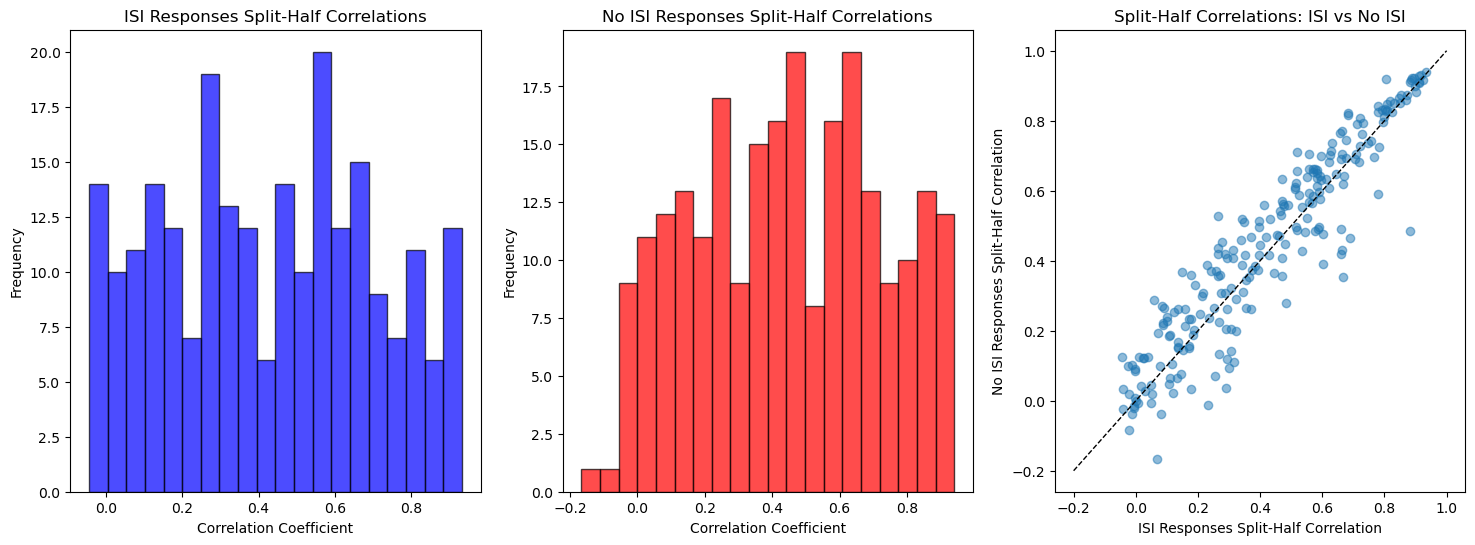

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].hist(isi_mean_split_half_corrs, bins=20, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_title('ISI Responses Split-Half Correlations')
axs[0].set_xlabel('Correlation Coefficient')
axs[0].set_ylabel('Frequency')
axs[1].hist(noisi_mean_split_half_corrs, bins=20, color='red', alpha=0.7, edgecolor='black')
axs[1].set_title('No ISI Responses Split-Half Correlations')
axs[1].set_xlabel('Correlation Coefficient')
axs[1].set_ylabel('Frequency')

# scatter plot
axs[2].scatter(isi_mean_split_half_corrs, noisi_mean_split_half_corrs, alpha=0.5)
axs[2].set_title('Split-Half Correlations: ISI vs No ISI')
axs[2].set_xlabel('ISI Responses Split-Half Correlation')
axs[2].set_ylabel('No ISI Responses Split-Half Correlation')
 # draw diagonal line
axs[2].plot([-0.2, 1], [-0.2, 1], color='black', linestyle='--', linewidth=1)

#axs[2].hist(isi_mean_split_half_corrs - noisi_mean_split_half_corrs, bins=20, color='green', alpha=0.7, edgecolor='black')
#axs[2].set_title('Difference in Split-Half Correlations (ISI - No ISI)')
#axs[2].set_xlabel('Difference in Correlation Coefficient')
#axs[2].set_ylabel('Frequency')

In [48]:
# Jenelle's Question: compare correlation between ISI and No ISI responses
def cross_condition_correlation(isi_responses, noisi_responses, n_splits=1000):
    """
    Calculate the cross-condition correlation between ISI and No ISI responses.
    
    Parameters:
    - isi_responses: 3D numpy array of ISI responses.
    - noisi_responses: 3D numpy array of No ISI responses. 
    - n_splits: Number of random splits to perform.
    """

    mean_isi_responses = np.mean(isi_responses, axis=0)
    cross_condition_corrs = np.zeros((n_splits, isi_responses.shape[2]))
    within_condition_corrs = np.zeros((n_splits, isi_responses.shape[2]))
    for split in tqdm(range(n_splits)):
        noisi_responses_permuted = np.random.permutation(noisi_responses)
        # Randomly split the trials into two halves
        split_1 = noisi_responses_permuted[:noisi_responses.shape[0]//2, :, :]
        split_2 = noisi_responses_permuted[noisi_responses.shape[0]//2:, :, :]
        split_1_means = np.mean(split_1, axis=0)
        split_2_means = np.mean(split_2, axis=0)

        for cell in range(isi_responses.shape[2]):
            # split half correlation
            within_condition_corrs[split, cell] = single_split_half_correlation(split_1[:, :, cell], split_2[:, :, cell])
            # cross condition correlation
            cross_condition_corrs[split, cell] = np.corrcoef(mean_isi_responses[:, cell], split_1_means[:, cell])[0, 1]
    
    return cross_condition_corrs, within_condition_corrs

In [49]:
cross_condidion_corrs, within_condition_corrs = cross_condition_correlation(test_responses_isi, test_responses_no_isi, n_splits=1000)

  1%|█                                                                                                                               | 8/1000 [00:00<00:28, 34.76it/s]/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.42it/s]


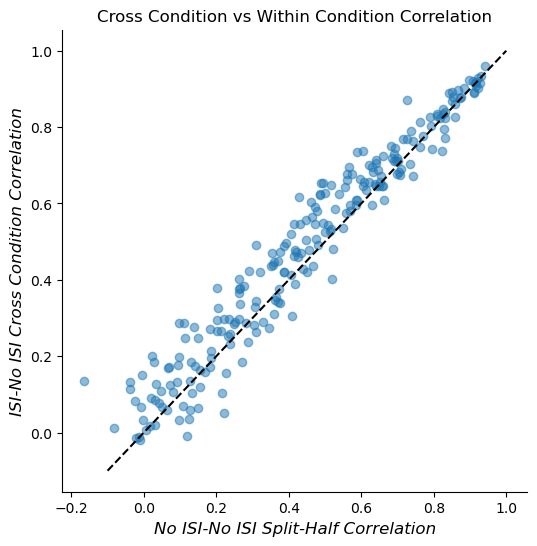

In [ ]:
mean_cross_condition_corrs = np.nanmean(cross_condidion_corrs, axis=0) # note: nanmean is used to ignore NaNs in the correlation calculations
mean_within_condition_corrs = np.nanmean(within_condition_corrs, axis=0) # note: nanmean is used to ignore NaNs in the correlation calculations

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

axs.scatter(mean_within_condition_corrs, mean_cross_condition_corrs, alpha=0.5)
axs.set_title('Cross Condition vs Within Condition Correlation')

# turn off top and right spines
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs.set_xlabel('No ISI-No ISI Split-Half Correlation', fontsize=12, fontstyle='italic')
axs.set_ylabel('ISI-No ISI Cross Condition Correlation', fontsize=12, fontstyle='italic')

# draw a diagonal line
min_val, max_val = -0.1, 1.0
axs.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
